# Тестовое задание для кандидатов на предстажировку Case Lab ML

В рамках тестового задания необходимо разработать веб-сервис для оценки комментариев (отзывов) к фильмам.

**Описание данных:**

В качестве исходных данных использовался открытый набор данных, который содержит в себе отзывы о фильмах, а также соответствующие им оценки рейтинга.

https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

## Подготовка данных

In [1]:
!pip install spacy -q
!pip install scikit-learn -q
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import spacy
import re
!spacy download en_core_web_sm -q

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords as nltk_stopwords

plt.rcParams["figure.figsize"] = (16,8)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tqdm import tqdm
from joblib import dump
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression)
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor)
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor)
from sklearn.metrics import (
    f1_score,
    mean_absolute_error)
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.pipeline import (
    Pipeline,
    make_pipeline)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

In [4]:
#Объявим константы

RANDOM_STATE = 42

### Загрузка данных

In [5]:
# ссылка на данные
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Загрузка и распаковка данных
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
# Путь к датасету
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [6]:
# Список файлов в директории dataset_dir
os.listdir(dataset_dir)

['README', 'train', 'imdbEr.txt', 'imdb.vocab', 'test']

In [7]:
# Путь к директории train
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_neg.txt',
 'neg',
 'pos',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_unsup.txt',
 'unsup']

In [8]:
# Путь к директории test
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['urls_pos.txt', 'urls_neg.txt', 'neg', 'pos', 'labeledBow.feat']

In [9]:
# Для проверки выведем один из файлов в директории train/pos
sample_file = os.path.join(train_dir, 'pos/0_9.txt')
with open(sample_file) as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [10]:
# Путь к директории train/pos (положительные отзывы)
train_dir_pos = os.path.join(train_dir, 'pos')

# Путь к директории train/neg (отрицательные отзывы)
train_dir_neg = os.path.join(train_dir, 'neg')

# Путь к директории train/pos (положительные отзывы)
test_dir_pos = os.path.join(test_dir, 'pos')

# Путь к директории train/neg (отрицательные отзывы)
test_dir_neg = os.path.join(test_dir, 'neg')

Для оптимизации создания датафреймов напишем функцию, которая на вход принимает ссылку на директорию и бинарный признак 1/0 (положительный/отрицательный отзыв). И на выходе получаем датафрейм с признаками:
- 'id' -  уникальный идентификатор отзыва
- 'rating' - рейтинг
- 'text' - текст отзыва
- 'pos_neg' - бинарный признак 1/0 (положительный/отрицательный отзыв)

In [11]:
# функция для создания датасетов
def create_data(dir_data, n):
  data = []
  for file in os.listdir(dir_data):
    file_path = os.path.join(dir_data, file)
    with open(file_path, 'r') as f:
        id, rating = file.split('_')
        text = f.read()
        data.append([id, rating, text])
  df = pd.DataFrame(data, columns=['id', 'rating', 'text'])
  df['rating'] = df['rating'].str.replace('.txt', '').astype(int)
  df['id'] = df['id'].astype(int)
  df['pos_neg'] = n
  return df


In [12]:
# Создадим датасет с тренировочными положительными отзывами
data_train_pos = create_data(train_dir_pos, 1)
data_train_pos.head()

,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

In [13]:
# Создадим датасет с тренировочными отрицательными отзывами
data_train_neg = create_data(train_dir_neg, 0)
data_train_neg.head()

,id,rating,text,pos_neg
0,9300,1,"Spoiler Alert Well I think this movie is probably the worst film ever made. Probably in the style of Ed Wood(without the heart). The lightning is terrible. The music is very bad(piano and orgue... come on!). The acting is... well there is no acting!<br /><br />There's a guy who actually goes in the wood to search for his missing wife and take the time to have sex with a stranger.<br /><br />The killer is a fat, unscary clown who couldn't outrun a turtle!<br /><br />Every members of the cast is stupid and the director put every clichés of slashers movies in the film without effort.<br /><br />The end is so far the most stupid ever made. Think about it: The guy(ken hebert) who's acting skill is about the same as his writing(he's the brain behind this flop) invite a co-worker and two of his friends to his cabin for the week-end and kills them... On monday morning he goes back to is office like nothing happen.<br /><br />The tragedy is that Mr.Hebert try to make us beleive that it's a family affair that goes on for generation(his uncle is the clown killer)<br /><br />So of course NO cops are gonna question him after his co-worker goes missing...<br /><br />WHATEVER.<br /><br />",0
1,4271,4,"Typical thriller, has been done many times before. Simple plot outline; cop Liotta becomes obsessed with Russell's wife, and he tries to bump off good ol' Kurt so he can have her. This is beyond predictable, it doesn't even try to make you guess, the plot is the plot and there's no thinking outside the box here. I guess then the only reason to watch it is to see how it develops, but nothing is done originally or interestingly. There's not really anything to say about this film, it's not particularly bad, but there's no good points either. Russell plays Russell and you know what you're gonna get when you see him in a film. Ditto Liotta. Stowe has an annoying Cher-esque voice. I read the plot outline and I could see the film in my head, it was so obvious and basic. I watched it and it rolled out in front of my eyes exactly as I had imagined. I felt not a drop of emotion throughout. I have no feeling towards this film, it's as if I never even watched it. Considering this, it's a pretty pointless film isn't it? Still, I'll give it 3/10 for some reason.",0
2,6213,1,"This movie made it into one of my top 10 most awful movies. Horrible. <br /><br />There wasn't a continuous minute where there wasn't a fight with one monster or another. There was no chance for any character development, they were too busy running from one sword fight to another. I had no emotional attachment (except to the big bad machine that wanted to destroy them) <br /><br />Scenes were blatantly stolen from other movies, LOTR, Star Wars and Matrix. <br /><br />Examples<br /><br />>The ghost scene at the end was stolen from the final scene of the old Star Wars with Yoda, Obee One and Vader. <br /><br />>The spider machine in the beginning was exactly like Frodo being attacked by the spider in Return of the Kings. (Elijah Wood is the victim in both films) and wait......it hypnotizes (stings) its victim and wraps them up.....uh hello????<br /><br />>And the whole machine vs. humans theme WAS the Matrix..or Terminator.....<br /><br />There are more examples but why waste the time? And will someone tell me what was with the Nazi's?!?! Nazi's???? <br /><br />There was a juvenile story line rushed to a juvenile conclusion. The movie could not decide if it was a children's movie or an adult movie and wasn't much of either. <br /><br />Just awful. A real disappointment to say the least. Save your money.",0
3,2813,1,"Normally I would never rent a movie like this, because you know it's going to be bad just by looking at the box. I rented seven movies at the same time, including Nightmare on Elm Street 5, 6 and Wes Craven's New Nightmare. Unfortunately, when I got home I found out the videostore-guy gave me the wrong tape. In the box of Wes Craven's New Night

In [14]:
# Создадим датасет с тестовыми положительными отзывами
data_test_pos = create_data(test_dir_pos, 1)
data_test_pos.head()

,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1
3,1865,8,"I saw this film on 19SEP2009 at the Cambridge Film Festival. <br /><br />The Beagle's only in a couple of short flashbacks, the whole thing is about Darwin's life from 1841 to 1859, when he was ensconced in Kent with his growing family, 200+ pages of Origin had already been drafted and he was wondering whether to complete the book. <br /><br />The script is based on Randal Keynes's book Annie's Box (Annie, Charles's daughter, died when she was 10). It is mostly a family drama, but does include sex scenes - however, the participants are married, both on and off screen. Not too exciting, not much science but a well-made film that's pleasant to watch and pushes the right emotional buttons. A bit of a romantic weepie, actually. I suppose the conclusion is that you can be an agnostic free-thinking scientist from an atheist family background and still be an emotional romantic as well as an excellent father. <br /><br />Som

In [15]:
# Создадим датасет с тестовыми отрицательными отзывами
data_test_neg = create_data(test_dir_neg, 0)
data_test_neg.head()

,id,rating,text,pos_neg
0,3165,3,"This love story between an American journalist and an Eurasian lady doctor does not contain much conflict, since she is largely Westernized (having studied in London), nor any fireworks, since she behaves rather restrained. What little interest the story manages to raise is knocked down further by their wooden dialogs. They are supposed to be two cosmopolitan intellectuals, but talk as if the words are put in their mouths by a Hollywood hack who is not much of one himself. The movie also suffers from an amazing lack of realism - a completely deserted beach in crowded little Hongkong, overrun by a million Chinese refugees? And a presumably accomplished American journalist in his 40s who doesn't know what a hysterectomy is? Hollywood ideas. Finally ""the song"". After hearing it an estimated twenty times throughout the movie, starting right with the credits, it tends to loose some of its emotional impact, sorry to say.",0
1,4597,3,"After Matt Dillon's phenomenal performance in CRASH, most will probably rush to pick up a copy of FACTOTUM to see if Dillon is for real or simply got a lucky rebound from a great script.<br /><br />Well, Factotum certainly has its moments, but the plainness of ...everything will most likely turn viewers off. However nothing should be taken away from Dillon. His performance is wonderful and full of excellent deadpan humor, proving he's a solid actor with significant chops; it's just a shame about the directing and script.<br /><br />The story is about Henry ""Hank"" Chinaski (Dillon) and his refusal to conform to anything resembling normalcy. He quits or gets fired from jobs in mere minutes, only to find himself back in a dreary pub meeting even drearier women while trying to write a nonconformist novel. We never really know what the novel is about except that it involves ""everything"" (cancer, movies, you, me).<br /><br />Skipping from workplace to workplace and constantly returning to Jan (Lili Taylor, THE HAUNTING), a loser girlfriend who's just as dispiriting as himself, Hank tries vainly to discover what his life is supposed to hold for him. Whether he ever learns what that is is up for interpretation. Some may say that he never does, while others might argue that his life is simply a path to obscurity.<br /><br />Regardless, there's not much substance to Factotum even with Matt Dillon's fine performance. The story meanders through Hank's life without much thought given as to where to take the audience. And that's a shame. Dillon's performance would've shone even brighter if given a decent script.",0
2,9979,4,"""Caligula"" shares many of the same attributes as the 1970 ""Fellini Satyricon"" with bizarre sights, freakishness, and depictions of sexual excesses all set in the ""glory"" of ancient Rome. But Fellini it ain't... First of all it is not as entertaining. Far too much screen time is devoted to bug-eyed, rubber-faced McDowell in the titular role. His performance is far too fey and campy to be convincing. The portrayals by Jay Robinson in ""The Robe"" (1953) and David Cain-Haughton in ""Emperor Caligula"" (1983) are far more persuasive and believable, with the latter being the most nuanced. Relief could have been judiciously provided by developing the surrounding characters more fully. As it is, they are little more than cyphers. One example is the role of Macro, played by Guido Mannari who has tremendous screen presence in an important role, but is mostly left in the background. The only positive features to credit are the adroit use of some Prokofiev and Stravinsky themes in the music score and the inclusion of some of the distasteful but nevertheless accurate actions of the despot. These two factors are far less than what is needed to relieve the prevailing tedium, however.",0
3,11421,3,There wasn't much thought put into the story line on many fronts. This is a good action movie but that's about it.<br /><br />- The movie states that the lycans were kept 

Объединим датафреймы:
- data_train_pos и data_train_neg в датафрейм data_train
- data_test_pos и data_test_neg в датафрейм data_test

In [16]:
# Создадим датафрейм data_train
data_train = pd.concat([data_train_pos, data_train_neg], axis=0).reset_index(drop=True)
data_train.head(3)

,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

In [17]:
# Создадим датафрейм data_test
data_test = pd.concat([data_test_pos, data_test_neg], axis=0).reset_index(drop=True)
data_test.head(3)

,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1


Данные загрузили, теперь изучим общую информацию о датафреймах.

### Изучение общей информации

In [18]:
# В целях оптимизации, напишем функцию для получения общей информации о датасете
def describe_df(df, name):
    print('размер датафрейма', name, ':', df.shape)
    print('_'*125)

    print('Первые 3 строки датафрейма', name)
    display(df.head(3))
    print('_'*125)

    print('Последнии 3 строки датафрейма', name)
    display(df.tail(3))
    print('_'*125)

    print('Информация о датафрейме', name)
    df.info()
    print('_'*125)

    print('Описание датафрейма', name)
    display(df.describe().T)
    print('_'*125)

    print('Количество явных дубликатов в датафрейте', name, ':', df.duplicated().sum())
    print('Количество пропусков в датафрейте', name, ':', '\n', df.isna().sum())

    print('*'*125)

In [19]:
#Вызовем функцию для датасета 'data_train'
describe_df(data_train, 'data_train')

размер датафрейма data_train : (25000, 4)
_____________________________________________________________________________________________________________________________
Первые 3 строки датафрейма data_train


,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

_____________________________________________________________________________________________________________________________
Последнии 3 строки датафрейма data_train


,id,rating,text,pos_neg
24997,8751,2,"How Disney can you get? Preppy rich girls act like idiots, buy a bunch of stuff, and get taught a lesson. Is Disney trying to send a lesson to itself? That maybe while buying everything it should maybe still be human? Whatever the psycho-analysis, this movie sucked.<br /><br />The girls want a rich party for their rich lives. But then money disappears and they have to use their riches to get the milk plant (yes, milk) going to employ the workers. They keep it afloat until daddy comes home. And the man at the beginning, who appears to be the one that takes the money, is the one. But the ending is dumb. Webcam in the Cayman Islands? Huh? Not worth my time ever again. <br /><br />But it is better than Howl's Moving Castle. ""D-""",0
24998,11637,4,"Uwe Boll has done the impossible: create a game adaptation that stays at least somewhat true to the game; he has turned a game full of antisocial and offensive content into a movie full of antisocial and offensive content. So, as an adaptation, it's a success.<br /><br />Unfortunately, it's still Uwe Boll we are dealing with here, so don't expect the movie to be actually any good. while it does have it's moment, ""Postal"" wears out his welcome very fast and becomes a pain to sit through.<br /><br />At its core, Postal is a satire on the United States, as done by a twelve year old kid. Boll seems to think that offensiveness is linearly proportional to comedic value: the more offensive, the funnier, and the more exaggerated the funnier. This results in a movie that sets new levels of tastelessness while being extremely hit and miss. Yes, some gags do work but it seems to be pure luck. High points include the director satirizing himself, and people getting hit very violently by trucks and other vehicles. Low points include..well pretty much everything else.<br /><br />After the initial surprise wears off, Postal simply becomes a bore to watch. Yes there is a good joke every and good point ten minutes, but everything else consists of hordes of annoying characters shooting and chasing each other all over the place for what seems to be an eternity.<br /><br />This probably would have worked as a short movie, but it's just not enough content for something that lasts over 90 minutes (although it feels twice as long). There are nice ideas and nice tries, but they get hopelessly lost in endless and pointless action scenes and content that is offensive just for the sake of it 4/10",0
24999,1922,3,"About the baby: Why wasn't big brother assuming he'd be hungry for a bottle or some nourishment or a diaper change? He should have been screaming non-stop after that many hours without care. Definitely stupid to take the baby from a safe place when he didn't need to.<br /><br />And why was the road miraculously clear whenever anyone wanted to drive somewhere? Didn't any uprooted trees fall on the roads and block them?<br /><br />I can't imagine the cops at the roadblock not immediately following after any young person who would crash it, especially when they said it was dangerous to go there.<br /><br />That being said, it was nice to have a movie children could safely watch, for a change.",0


_____________________________________________________________________________________________________________________________
Информация о датафрейме data_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   rating   25000 non-null  int64 
 2   text     25000 non-null  object
 3   pos_neg  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма data_train


,count,mean,std,min,25%,50%,75%,max
id,25000.0,6249.50000,3608.511342,0.0,3124.75,6249.5,9374.25,12499.0
rating,25000.0,5.47772,3.466477,1.0,2.00,5.5,9.00,10.0
pos_neg,25000.0,0.50000,0.500010,0.0,0.00,0.5,1.00,1.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_train : 0
Количество пропусков в датафрейте data_train : 
 id         0
rating     0
text       0
pos_neg    0
dtype: int64
*****************************************************************************************************************************


In [20]:
#Вызовем функцию для датасета 'data_test'
describe_df(data_test, 'data_test')

размер датафрейма data_test : (25000, 4)
_____________________________________________________________________________________________________________________________
Первые 3 строки датафрейма data_test


,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1


_____________________________________________________________________________________________________________________________
Последнии 3 строки датафрейма data_test


,id,rating,text,pos_neg
24997,11637,4,"I enjoy science-fiction just as much as the next man but what the hell was that? Apparently shot over just three days using excess film stock left over from his previous film, 'Nana (1926),' this Jean Renoir short is a bewildering futuristic satire, produced on a budget that couldn't have been much more than zero. In the year 2028, following a great war, Africa has become the most civilised region on Earth, and what was formerly Europe has been designated ""Terres Inconnues (Unknown Land)."" An African explorer  played by Johnny Huggins, a Black man dressed up as a White man dressed up as a Black man, if you follow me  travels to the ruins of Paris in his spherical aircraft, and lands outside the lair of a Parisian savage (Catherine Hessling, then the director's wife) and her primate companion, perhaps the creepiest ape-man costume I've ever seen. The savage, as part of some bizarre sexual initiation ritual, starts showing the explorer the Charleston dance, which he is delighted to learn himself.<br /><br />It doesn't help the film that Hessling, who was wonderful the following year in Renoir's 'The Little Match Girl (1928),' isn't much of a dancer, though the extensive use of slow-motion adds a touch of surrealism to the ceremony. Furthermore, I'm quite shocked that Renoir would exploit his own wife as such a blatant sexual object  it doesn't come as a surprise to learn of their divorce just three years later! On the plus side, I did like the general sci-fi concept behind the film, and the slyly satiric touch of the reversing the racial roles usually typical in such stories as this. However, why Renoir decided to dress up his Black actor as a minstrel will remain a mystery for all of time. Silly, crude and quite pointless, 'Charleston Parade (1927)' is a cinematic oddity from one of cinema's most respected directors, and is perhaps an effort that he would have liked to forget. The DVD version came without a musical soundtrack, but I compromised with a selection of pieces from Dmitri Shostakovich.",0
24998,7479,1,"He seems to be a control freak. I have heard him comment on ""losing control of the show"" and tell another guest who brought live animals that he had one rule-""no snakes."" He needs to hire a comedy writer because his jokes are lame. The only reason I watch him is because he some some great guests and bands. <br /><br />I watched the Craig Ferguson show for a while but his show is even worse. He likes to bull sh** to burn time.I don't think either man has much of a future in late night talk shows.<br /><br />Daily also has the annoying habit of sticking his tongue out to lick his lips. He must do this at least 10 times a show. I do like the Joe Firstman band. Carson Daily needs to lighten up before it is too late.",0
24999,6291,1,"The movie is an adaptation of a Japanese story by the respected author Yukio Mishima. It simply doesn't make the transition into a credible story about Brits and Americans.<br /><br />The story moves sluggishly, especially the part where Miles and Kristofferson are separated and the director fills in with the cliched shots of a ship's prow cutting through the waves, and the little route line filling in on the maps, while their letters are heard in overvoice. The film moves so languidly that I even fast-forwarded through the sex and masturbation scenes which, although long, are not really either passionate or erotic. The film did achieve a measure of notoriety when Kristofferson's then-wife divorced him for extra-curricular activities with Miss Miles during the filming. I guess they enjoyed the sex scenes, but it isn't quite the same for a viewer.<br /><br />There are no characters to hang on to. The sexually frustrated widow is unlikeable, the little kid is detestable. Kristofferson is amiable enough, but he just doesn't have the acting skills to bring much to the role, although perhaps we don't really want get too involved with him, considering h

_____________________________________________________________________________________________________________________________
Информация о датафрейме data_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   rating   25000 non-null  int64 
 2   text     25000 non-null  object
 3   pos_neg  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB
_____________________________________________________________________________________________________________________________
Описание датафрейма data_test


,count,mean,std,min,25%,50%,75%,max
id,25000.0,6249.50000,3608.511342,0.0,3124.75,6249.5,9374.25,12499.0
rating,25000.0,5.51296,3.490902,1.0,2.00,5.5,9.00,10.0
pos_neg,25000.0,0.50000,0.500010,0.0,0.00,0.5,1.00,1.0


_____________________________________________________________________________________________________________________________
Количество явных дубликатов в датафрейте data_test : 0
Количество пропусков в датафрейте data_test : 
 id         0
rating     0
text       0
pos_neg    0
dtype: int64
*****************************************************************************************************************************


**Вывод** Данные в датасетах соответствуют описанию.

Количество сток - 25 000, Количество столбцов - 4.

Тип данных указан верно, пропусков и дубликатов в датафреймах нет, название столбцов сответсвуют стилю написания snake_case

### Исследовательский анализ данных

#### 'rating' и 'pos_neg'

Построим распределение признаков 'rating' и 'pos_neg'

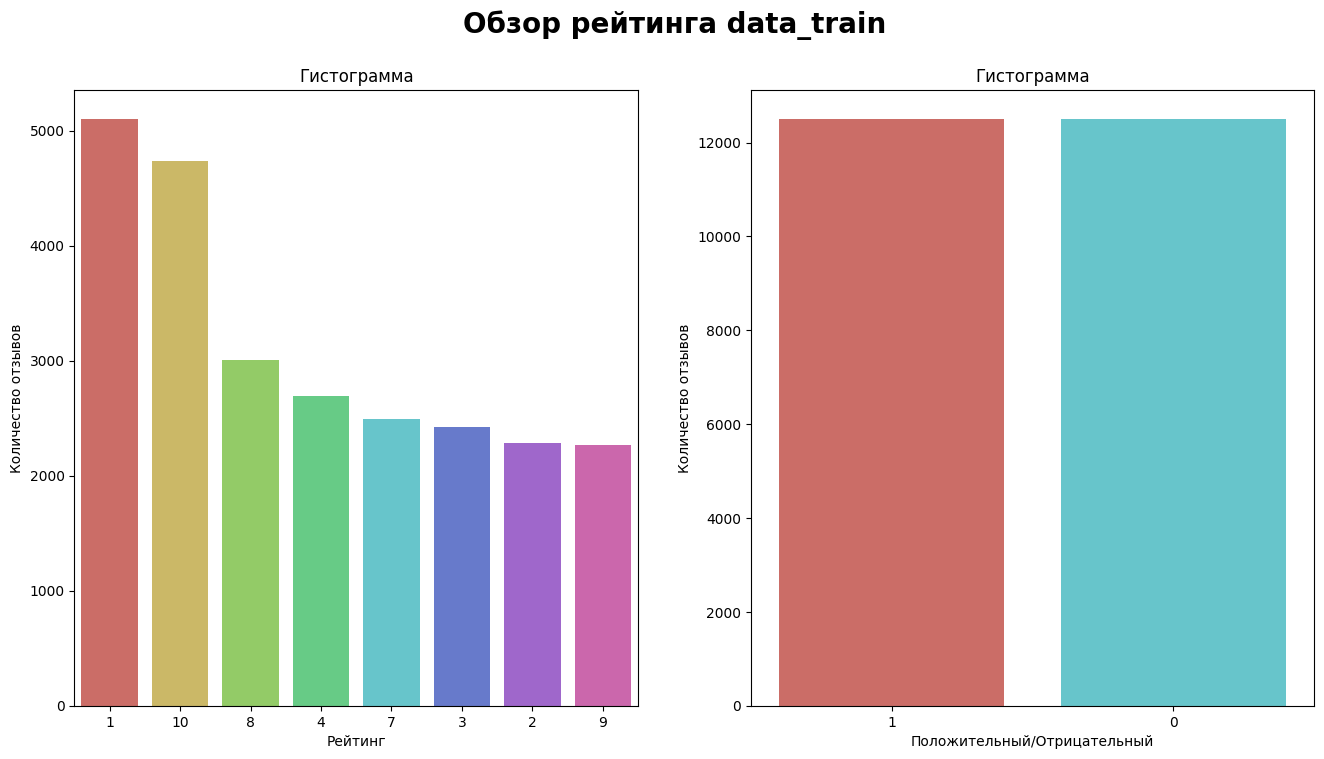

In [21]:
# Построим распределение признаков 'rating' и 'pos_neg' для data_train
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(f'Обзор рейтинга data_train', fontsize = 20, fontweight='bold')

sns.countplot(data=data_train, x='rating', ax=ax[0], order=data_train['rating'].value_counts().index, palette='hls')
sns.countplot(data=data_train, x='pos_neg', ax=ax[1], order=data_train['pos_neg'].value_counts().index, palette='hls')

ax[0].set_title('Гистограмма')
ax[0].set_xlabel('Рейтинг')
ax[0].set_ylabel('Количество отзывов')

ax[1].set_title('Гистограмма')
ax[1].set_xlabel('Положительный/Отрицательный')
ax[1].set_ylabel('Количество отзывов')

plt.show()

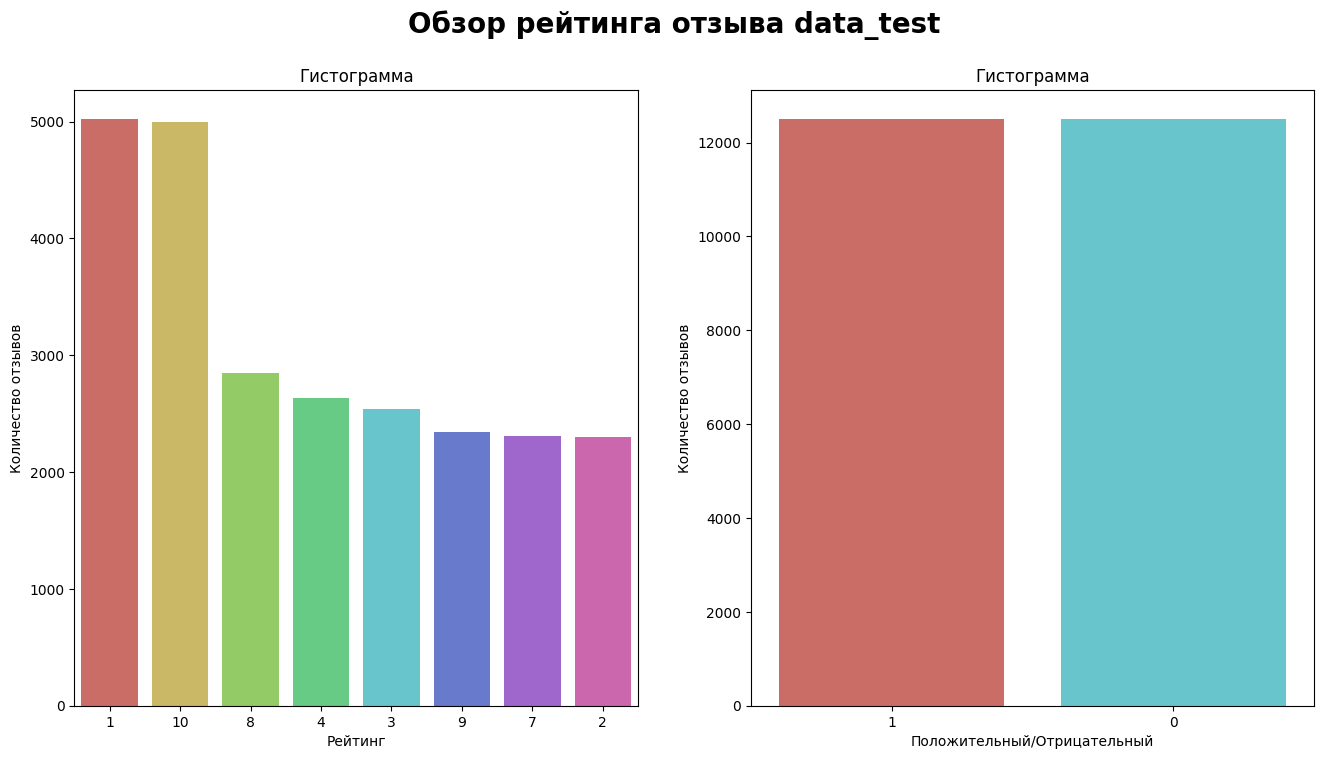

In [22]:
# Построим распределение признаков 'rating' и 'pos_neg' для data_test
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(f'Обзор рейтинга отзыва data_test', fontsize = 20, fontweight='bold')

sns.countplot(data=data_test, x='rating', ax=ax[0], order=data_test['rating'].value_counts().index, palette='hls')
sns.countplot(data=data_test, x='pos_neg', ax=ax[1], order=data_test['pos_neg'].value_counts().index, palette='hls')

ax[0].set_title('Гистограмма')
ax[0].set_xlabel('Рейтинг')
ax[0].set_ylabel('Количество отзывов')

ax[1].set_title('Гистограмма')
ax[1].set_xlabel('Положительный/Отрицательный')
ax[1].set_ylabel('Количество отзывов')

plt.show()


In [23]:
data_train['rating'].describe()

,rating
count,25000.000000
mean,5.477720
std,3.466477
min,1.000000
25%,2.000000
50%,5.500000
75%,9.000000
max,10.000000


In [24]:
data_test['rating'].describe()

,rating
count,25000.000000
mean,5.512960
std,3.490902
min,1.000000
25%,2.000000
50%,5.500000
75%,9.000000
max,10.000000


Дисбалансов классов нет. Среднее и медианное значение рейтингов совпадают. Очень много пограничных оценок 1 и 10, когда пользователи оцениваю, что фильм им очень понравился, либо совсем не понравился.

#### text

In [25]:
data_train.head(3)

,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

In [26]:
data_test.head(3)

,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1


Видим, что отзывы написаны на английском языке. Для отзывов используется разный регистр и неинформативные знаки. Сделаем копии датасетов добавим новый признак длина отзыва, проверим влияет ли длина отзыва на рейтинг и приведем данные к единому формату

In [27]:
data_train_ml = data_train.copy()
data_test_ml = data_test.copy()

In [28]:
# Добавим столбец длина стоки в data_train_ml
data_train_ml['len'] = data_train_ml['text'].apply(len)
data_train_ml.head(3)

,id,rating,text,pos_neg,len
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1,2981
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in

In [29]:
data_train_ml['len'].describe()

,len
count,25000.00000
mean,1325.06964
std,1003.13367
min,52.00000
25%,702.00000
50%,979.00000
75%,1614.00000
max,13704.00000


Видим, что длина самых длинных отзывов более 10 000 символов

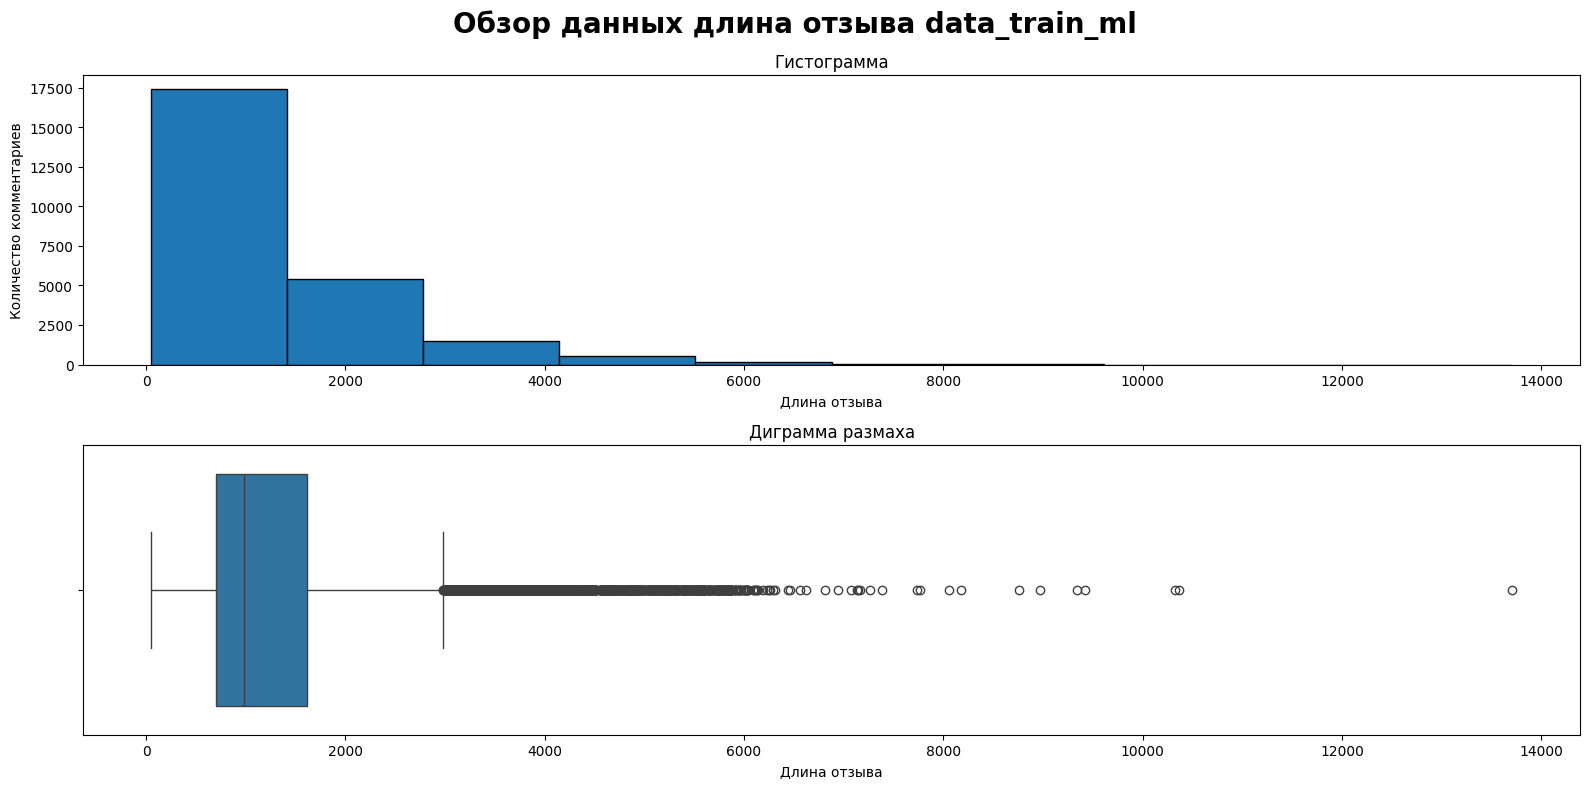

In [30]:
# Построим графики распределения признака len
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle(f'Обзор данных длина отзыва data_train_ml', fontsize = 20, fontweight='bold')

data_train_ml['len'].plot(ax=ax[0], kind='hist', edgecolor='black')

sns.boxplot(x = data_train_ml['len'], ax=ax[1])

ax[0].set_title('Гистограмма')
ax[0].set_xlabel('Длина отзыва')
ax[0].set_ylabel('Количество комментариев')


ax[1].set_title('Диграмма размаха')
ax[1].set_xlabel('Длина отзыва')

plt.tight_layout()
plt.show()

In [31]:
#Выведем самые длинные отзывы
data_train_ml.sort_values(by='len').tail()

id  rating  \
12369   2662      10   
164     4076      10   
2725   10044       9   
9120    4383       9   
874     1175       9   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Выбросы, которые мы видим на диаграмме размаха удалять не будем, так как данные отзывы реальны, в них пользователи высказывают подробно свое мнение.

Проверим зависит ли положительная оценка отзывов от его длины.

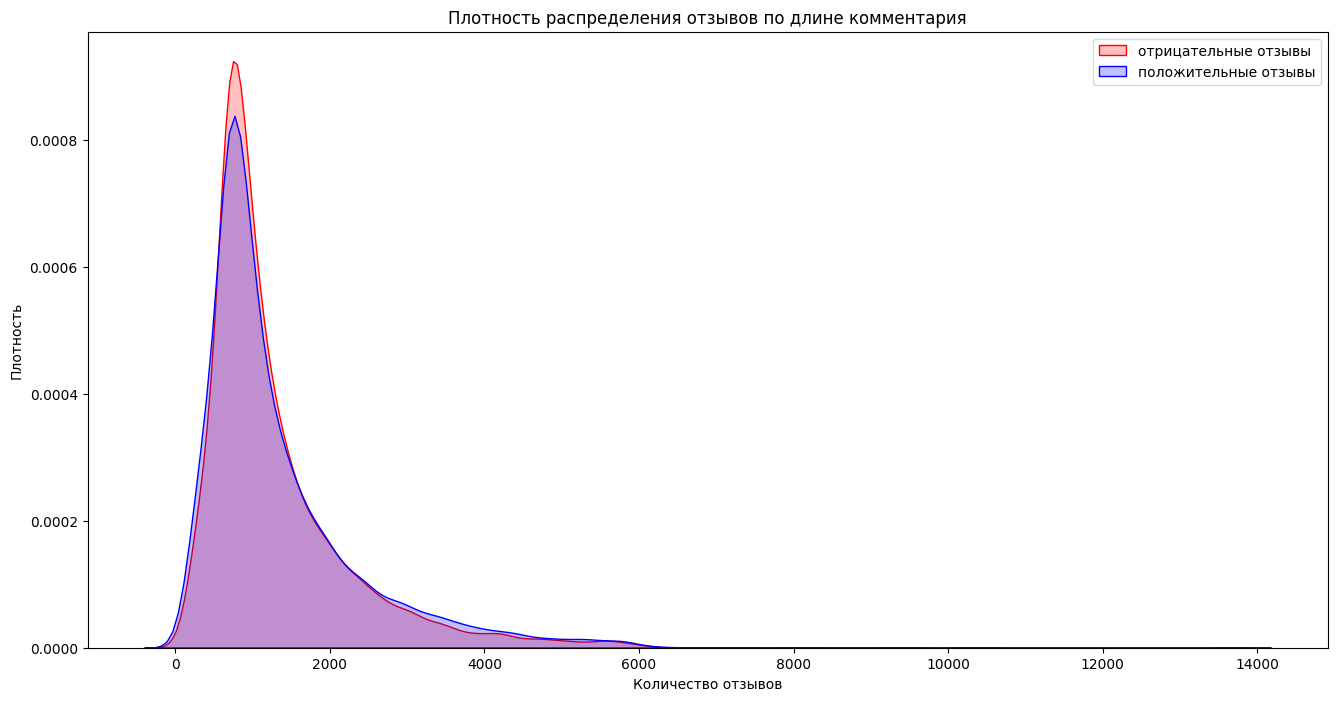

In [32]:
#Разобьем данные по признаку длина отзыва на позитивные и негативные комментарии.
data_train_ml_pos = data_train_ml[data_train_ml['pos_neg'] == 1]['len']
data_train_ml_neg = data_train_ml[data_train_ml['pos_neg'] == 0]['len']

#Пострим распределение
plt.figure()
sns.kdeplot(data_train_ml_neg, fill=True, color='red', label='отрицательные отзывы')
sns.kdeplot(data_train_ml_pos, fill=True, color='blue', label='положительные отзывы')
plt.title('Плотность распределения отзывов по длине комментария')
plt.xlabel('Количество отзывов')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Из графика можем сделать вывод, что длина отзыва не зависит от его оценки.

**Очистка текста + лемматизация**

In [33]:
#Объявим лемматизатор
nlp = spacy.load("en_core_web_sm")

In [34]:
def clear_text(text):
    #перевод текста в нижний регистр
    text = text.lower()
    # Удаление всех символов, кроме английских букв и пробелов
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Удаление лишних пробелов
    text = " ".join(text.split())
    return text

In [35]:
# Убедимся на простом примере, что он работает
sentence1 = "The striped bats are hanging on their feet for best//  "
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

                                                      text
0  The striped bats are hanging on their feet for best//  
1            you should be ashamed of yourself went worked


In [36]:
# Убедимся на простом примере, что он работает
lemm1 = []

for i in tqdm(range(len(df_my))):
    tokens = clear_text(df_my.text[i])
    tokens = nlp(tokens)
    lemm1.append(" ".join([token.lemma_ for token in tokens]))

df_my['lemm_text'] =  lemm1
df_my

100%|██████████| 2/2 [00:00<00:00, 32.65it/s]


,text,lemm_text
0,The striped bats are hanging on their feet for best//,the stripe bat be hang on their foot for good
1,you should be ashamed of yourself went worked,you should be ashamed of yourself go work


Лемматизатор работает (striped ------> stripe, went -------> go), применим его для нашего датасета

In [37]:
# Применим лемматизатор к датафрейму data_train_ml
lemm = []

for i in tqdm(range(len(data_train_ml))):
    tokens = clear_text(data_train_ml.text[i])
    tokens = nlp(tokens)
    lemm.append(" ".join([token.lemma_ for token in tokens]))

data_train_ml['lemm_text'] =  lemm
data_train_ml.head(3)

100%|██████████| 25000/25000 [21:05<00:00, 19.75it/s]


,id,rating,text,pos_neg,len,lemm_text
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1,2981,a year or so ago I be watch the tv news when a story be broadcast about a zombie movie be film in my area since then I have pay particular attention to this movie call fido as it finish production and begin play at festival two week ago fido begin play in my local theater and just yesterday I read a newspaper article which state fido be not attract audience in it s limited release with the exception of our local theater in fact here it be outdraw all other show at the paramount theater include of course this make sense as many local want to see their city on screen or spot themselves roam around in zombie make up and for any other local who haven t see fido yet but be consider it I can say there be many image on screen from the school to city park to the forbidden zone that you will recognize in fact they make the okanagan valley look beautiful that s right beautiful scenery in a zombie movie however fido itself be a very good movie yes despite its

In [38]:
# Применим лемматизатор к датафрейму data_test_ml
lemm = []

for i in tqdm(range(len(data_test_ml))):
    tokens = clear_text(data_test_ml.text[i])
    tokens = nlp(tokens)
    lemm.append(" ".join([token.lemma_ for token in tokens]))

data_test_ml['lemm_text'] =  lemm
data_test_ml.head(3)

100%|██████████| 25000/25000 [20:16<00:00, 20.55it/s]


,id,rating,text,pos_neg,lemm_text
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1,hoppity be a charming if slightly phycadelic animate movie that consider it be make in the have stand the test of time incredibly well now I have to admit I have a soft spot for hoppitygoe to town as it be call in the united kingdom having watch a vhs version tape of the tv by our parent many time with my sibling imagine my surprise when I wake up this morning just in time to catch it on channel four at never the less the film be just as delightful as I remember it with the animation stand the test of time and a lovely moral tale which should appeal to parent and child alike maybe one day I to shall share this forget classic with child of my own with a nice running time for kid min s and a simple yet involve storyline there really be something for everyone in this tale of the little guy come good I really could see this be successfully remade in cgi take note pixar
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1,to be frank this be probably the good version in my book as a sound movie version of the jazz singer the version be really a silent movie despite its build up as the first talkie br br danny thomas be a great comedian and he sing very well he do the jewish stuff with feel peggy lee be great and any film that have she be always entertain allan joslyn be not too entertaining and we could have do without he one question since when do cantor live in such luxurious house
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both 

Итак, мы привели текст к нижнему регистру, очистили от ненужных символов и лемматизировали (привели слова к начальным формам). Лемматизированный текст находится в столбце 'lemm_text'.

**Вывод**

На этапе исследовательского анализа данных:

Для признака text
- Видим, что отзывы написаны на английском языке. Для отзывов используется разный регистр и неинформативные знаки. Сделали копию датасета и привели текст к нижнему регистру, очистили от ненужных символов и лемматизировали (привели слова к начальным формам). Лемматизированный текст находится в столбце 'lemm_text'.
- В датасет с тренировочными данными добавили признак, длина комментария. Определили, что длина самых длинных комментариев превышает 10 000 знаков. Сделали вывод, положительность/отрицательность отзыва не зависит от его длины.

Для признака pos_neg - целевой признак

- Содержит два значения 0 и 1.
- Дисбаланса классов нет.

Для признака rating - целевой признак

- содержит 10 значений от 1 до 10.
- Значения 1 и 10 встречаются чаще остальных


## Обучение моделей

### **Задача классификации**

Предсказание бинарного признака pos_neg

In [39]:
#разделим наши данные на тренировочную и тестовую выборки. Выделим входные и целевой признаки

X_train = data_train_ml['lemm_text']
X_test = data_test_ml['lemm_text']
y_train =  data_train_ml['pos_neg']
y_test = data_test_ml['pos_neg']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [40]:
# найдём стоп-слова (слова без смысловой нагрузки)
stopwords = list(nltk_stopwords.words('english'))

In [41]:
# создадим счётчик и передадим в него список стоп-слов
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [42]:
# считаем величину TF-IDF

train_tf_idf = count_tf_idf.fit_transform(X_train)
test_tf_idf = count_tf_idf.transform(X_test)

In [43]:
print("Размер матрицы train:", train_tf_idf.shape)
print("Размер матрицы test:", test_tf_idf.shape)

Размер матрицы train: (25000, 60705)
Размер матрицы test: (25000, 60705)


Закодировали признаки с помощью TFIDF

Несмотря на то, что классы у нас сбалансированы, мы будем использовать F1-меру, так как она учитывает как точность, так и полноту модели.


In [44]:
# #Определим функцию grid для подбора параметров
def grid(model, params):
    pipeline = Pipeline([('model', model)])
    grid = GridSearchCV(
        pipeline,
        cv = 5,
        n_jobs = -1,
        param_grid = params ,
        scoring = 'f1',
        verbose = False)
    grid.fit(train_tf_idf, y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

#### LogisticRegression

In [45]:
#Логистическая регресия
log_reg = grid(LogisticRegression(), {"model__C":range(5,15), "model__penalty":["l1", "l2"], "model__solver": ["liblinear"]})

Лучший результат: 0.8902593124859521
Лучшие параметры: {'model__C': 5, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


#### DecisionTreeClassifier

In [46]:
#DecisionTreeClassifier
dec_tree = grid(DecisionTreeClassifier(), {'model__class_weight':['balanced'],
                                           'model__max_depth':range(1,10),
                                           'model__max_features': range(1,10)})

Лучший результат: 0.6666666737825212
Лучшие параметры: {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__max_features': 1}


#### CatBoostClassifier

In [47]:
# #CatBoostClassifier
# cat_boost = grid(CatBoostClassifier(logging_level='Silent'), {'model__depth': [2, 4, 6],
#                  'model__learning_rate' : [0.05, 0.1],
#                   'model__iterations' : [50, 100]})

Принт скрин выполнения кода
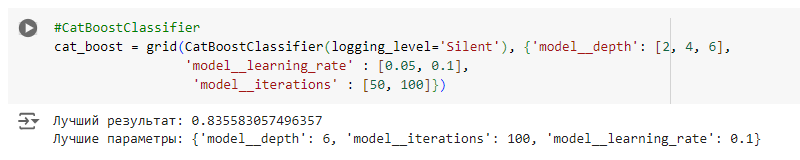

*Комментарий к работе*

На прошлом шаге подобрала лучшие параметры для модели CatBoostClassifier, сейчас уже запускаю функцию grid только для них, так она очень долго работает

In [48]:
#CatBoostClassifier
cat_boost = grid(CatBoostClassifier(logging_level='Silent'), {'model__depth': [6],
                 'model__learning_rate' : [0.1],
                  'model__iterations' : [100]})

Лучший результат: 0.8386881283925985
Лучшие параметры: {'model__depth': 6, 'model__iterations': 100, 'model__learning_rate': 0.1}


In [49]:
# Создадим датафрйм с результатами
results = pd.DataFrame({'Модель': ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
                        'f1_score': [log_reg.best_score_, dec_tree.best_score_, cat_boost.best_score_]})
display(results.sort_values(by='f1_score', ascending=False))

,Модель,f1_score
0,LogisticRegression,0.890259
2,CatBoostClassifier,0.838688
1,DecisionTreeClassifier,0.666667


Лучше всего на себя показала модель Логистической регрессии, к тому же она отрабатывает быстрее всех.

Чтобы развернуть модель на Django, выгрузим ее.

In [50]:
# Выгружаем лучшую модель, чтобы развернуть ее на Django
dump(log_reg.best_estimator_, 'model_clas.joblib')

['model_clas.joblib']

In [51]:
# Получаем мешок слов
vocabulary = count_tf_idf.get_feature_names_out()
vocabulary = vocabulary.tolist()
# Выгружаем мешок слов
dump(vocabulary, 'vocabulary.json')

['vocabulary.json']

#### Тестирование моделей

In [52]:
# Проверим качество лучшей модели (LogisticRegression) на тестовой выборке.
y_pred = log_reg.predict(test_tf_idf)
f1_score_pred = f1_score(y_test, y_pred)
f1_score_pred

0.8742273039473153

Итак, лучшая модель (LogisticRegression) на тестовой выборке показала отличные результаты.

### **Задача регресии**

Предсказание признака raiting

In [53]:
#разделим наши данные на тренировочную и тестовую выборки. Выделим входные и целевой признаки

X_train_reg = data_train_ml['lemm_text']
X_test_reg = data_test_ml['lemm_text']
y_train_reg =  data_train_ml['rating']
y_test_reg = data_test_ml['rating']

X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((25000,), (25000,), (25000,), (25000,))

In [54]:
# считаем величину TF-IDF

train_tf_idf_reg = count_tf_idf.fit_transform(X_train_reg)
train_tf_idf_reg = count_tf_idf.transform(X_train_reg)

In [55]:
print("Размер матрицы train:", train_tf_idf_reg.shape)
print("Размер матрицы test:", train_tf_idf_reg.shape)

Размер матрицы train: (25000, 60705)
Размер матрицы test: (25000, 60705)


Закодировали признаки с помощью TFIDF

Для оценки качества модели буду использовать метрику MAE, она хорошо интерпитируема, не чувствительна к выбросам и направлению ошибки.

In [56]:
# #Определим функцию grid_reg для подбора параметров
def grid_reg(model, params):
    pipeline = Pipeline([('model', model)])
    grid = GridSearchCV(
        pipeline,
        cv = 5,
        n_jobs = -1,
        param_grid = params ,
        scoring = 'neg_mean_absolute_error',
        verbose = False)
    grid.fit(train_tf_idf_reg, y_train_reg)
    print('Метрика MAE:', round(abs(grid.best_score_),2))
    print('Лучшие параметры:', grid.best_params_)
    return grid

#### LinearRegression

In [57]:
#LinearRegression
lin_reg = grid_reg(LinearRegression(), {})

Метрика MAE: 2.82
Лучшие параметры: {}


#### CatBoostRegressor

In [58]:
# #CatBoostRegressor
# cat_boost_reg = grid_reg(CatBoostRegressor(logging_level='Silent', random_seed=RANDOM_STATE), {'model__depth': [2, 4, 6, 8],
#                  'model__learning_rate' : [0.1],
#                   'model__iterations' : [50]})

Принт скрин кода
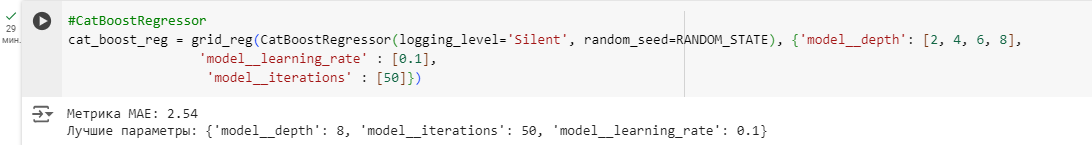

*Комментарий к работе*

На прошлом шаге подобрала лучшие параметры для модели CatBoostClassifier, сейчас уже запускаю функцию grid только для них, так она очень долго работает

In [59]:
#CatBoostRegressor
cat_boost_reg = grid_reg(CatBoostRegressor(logging_level='Silent', random_seed=RANDOM_STATE), {'model__depth': [8],
                 'model__learning_rate' : [0.1],
                  'model__iterations' : [50]})

Метрика MAE: 2.54
Лучшие параметры: {'model__depth': 8, 'model__iterations': 50, 'model__learning_rate': 0.1}


#### DecisionTreeRegressor

In [60]:
#DecisionTreeRegressor
dec_tree_reg = grid_reg(DecisionTreeRegressor(), {'model__max_depth':range(1,10),
                                           'model__max_features': range(1,10)})

Метрика MAE: 3.89
Лучшие параметры: {'model__max_depth': 8, 'model__max_features': 8}


#### LGBMRegressor

In [61]:
# # #LGBMRegressor
# lgbm_reg = grid_reg(LGBMRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100, 200],
#                                                       'model__max_depth':range(1,10)})

Принт скрин подбора параметров LGBMRegressor
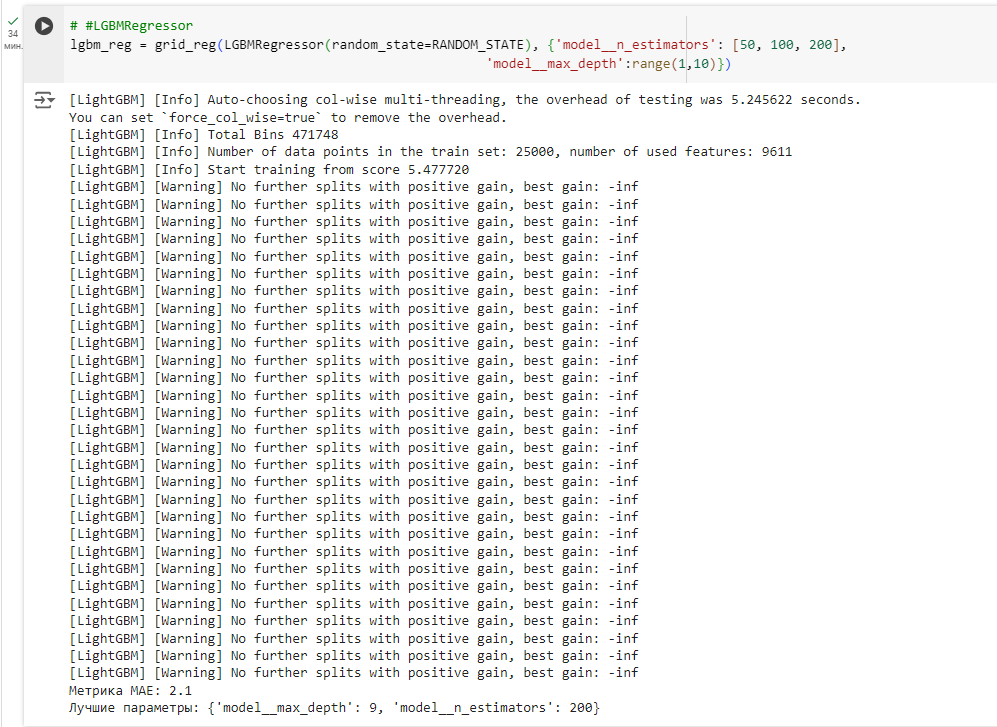

*Комментарий к работе*

На прошлом шаге подобрала лучшие параметры для модели LGBMRegressor, сейчас уже запускаю функцию grid только для них, так она очень долго работает

In [62]:
#LGBMRegressor
lgbm_reg = grid_reg(LGBMRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [200],
                                                      'model__max_depth':[9]})

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.959729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 471748
[LightGBM] [Info] Number of data points in the train set: 25000, number of used features: 9611
[LightGBM] [Info] Start training from score 5.477720
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

#### RandomForestRegressor

In [63]:
# #RandomForestRegressor
# random_forest_reg = grid_reg(RandomForestRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100],
#                                                       'model__max_depth':[2,4,6]})

Принт скрин с подбором коэффициентов
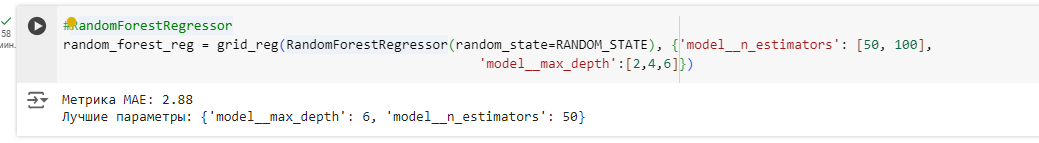

*Комментарий к работе*

На прошлом шаге подобрала лучшие параметры для модели RandomForestRegressor, сейчас уже запускаю функцию grid только для них, так она очень долго работает

In [64]:
#RandomForestRegressor
random_forest_reg = grid_reg(RandomForestRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50],
                                                      'model__max_depth':[6]})

Метрика MAE: 2.88
Лучшие параметры: {'model__max_depth': 6, 'model__n_estimators': 50}


In [65]:
# Создадим датафрйм с результатами
results = pd.DataFrame({'Модель': ['LinearRegression', 'CatBoostRegressor', 'DecisionTreeRegressor', 'LGBMRegressor', 'RandomForestRegressor'],
                        'MAE': [lin_reg.best_score_, cat_boost_reg.best_score_, dec_tree_reg.best_score_, lgbm_reg.best_score_, random_forest_reg.best_score_]})
results['MAE'] = abs(results['MAE'])
display(results.sort_values(by='MAE'))

,Модель,MAE
3,LGBMRegressor,2.094802
1,CatBoostRegressor,2.541224
0,LinearRegression,2.819562
4,RandomForestRegressor,2.884809
2,DecisionTreeRegressor,3.887507


Лучше всего на себя показала модель LGBMRegressor


#### Тестирование моделей



Проверим лучшую модель на тестовых данных.

In [66]:
# Проверим качество лучшей модели LGBMRegressor на тестовой выборке.
y_pred_reg = lgbm_reg.predict(test_tf_idf)
MAE_score_pred = mean_absolute_error(y_test_reg, y_pred_reg)
MAE_score_pred

1.8189441319155335

Не смотря на то, что модель обучалась на положительных данных, регрессионные модели все равно могут предсказывать как положительные, так и отрицательные значения. Это происходит потому, что модель пытается найти лучшую аппроксимацию, минимизируя ошибку предсказания, и может выйти за пределы диапазона обучающих данных. Поэтому напишем функцию которая переводит предсказания в целочисленные значения в диапазоне от 1 до 10. И посчитаем метрику на новых данных.

In [67]:
# Функция которая переводит предсказания в целочисленные значения в диапазоне от 1 до 10
def appd(list_res):
  new_list = []
  for i in list_res:
    if i < 1:
      new_list.append(1)
    elif i > 10:
      new_list.append(10)
    else:
      new_list.append(round(i))
  return new_list

new_pred = appd(y_pred_reg)

In [68]:

MAE_score_pred = mean_absolute_error(y_test_reg, new_pred)
MAE_score_pred

1.78492

Итак, лучшая модель (LGBMRegressor) на тестовой выборке показала хорошие результаты.

In [69]:
# Выгружаем лучшую модель, чтобы развернуть ее на Django
dump(lgbm_reg.best_estimator_, 'model_reg.joblib')

['model_reg.joblib']

#### Сравнение с константной моделью DummyRegressor

In [70]:
model_dr = DummyRegressor()
model_dr.fit(X_train_reg, y_train_reg)
pred_dr = model_dr.predict(X_test_reg)
mae_dr = mean_absolute_error(y_test_reg, pred_dr)
print(f'Метрика DummyRegressor MAE на тестовых данных: {mae_dr:.2f}\n')

Метрика DummyRegressor MAE на тестовых данных: 3.29



Модель LGBMRegressor значительно превзошла по эффективности константную модель. Это подтверждает, что разработка более сложных моделей и анализ данных для выявления новых закономерностей приводят к более точным прогнозам.

## Итоговый вывод

# Тестовое задание для кандидатов на предстажировку Case Lab ML
В рамках тестового задания необходимо разработать веб-сервис для оценки комментариев (отзывов) к фильмам.

**Описание данных:**

В качестве исходных данных использовался открытый набор данных, который содержит в себе отзывы о фильмах, а также соответствующие им оценки рейтинга.

https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

---

**Загрузка данных**

Из представленных данных сформировали датасеты.

Данные в датасетах соответствуют описанию.

Количество сток - 25 000, Количество столбцов - 4.

Тип данных указан верно, пропусков и дубликатов в датафреймах нет, название столбцов сответсвуют стилю написания snake_case

---
**Исследовательский анализ данных**

Для признака text:
- Видим, что отзывы написаны на английском языке. Для отзывов используется разный регистр и неинформативные знаки. Сделали копию датасета и привели текст к нижнему регистру, очистили от ненужных символов и лемматизировали (привели слова к начальным формам).
- В датасет с тренировочными данными добавили признак, длина комментария. Определили, что длина самых длинных комментариев превышает 10 000 знаков. Сделали вывод, положительность/отрицательность отзыва не зависит от его длины.

Для признака pos_neg - целевой признак

- Содержит два значения 0 и 1.
- Дисбаланса классов нет.

Для признака rating - целевой признак

- содержит 10 значений от 1 до 10.
- Значения 1 и 10 встречаются чаще остальных

Закодировали признаки с помощью TFIDF

---

**Обучение моделей**

**Задача классификации**

*Предсказание бинарного признака pos_neg*

Для поиска лучшей модели:
- была проведена подготовка данных
- в качестве моделей рассматривались: LogisticRegression(), CatBoostClassifier(), DecisionTreeClassifier()
- для моделей были подобраны гиперпараметры
- для перебора параметров использовали функцию grid
- в качестве метрики оценки модели была определена метрика f1_score

Лучшей моделью оказалась:
- LogisticRegression(C = 5, penalty = 'l2', solver = 'liblinear')
- Метрика лучшей модели на тренировочной выборке: 0.89
- Метрика f1_score на тестовых данных: 0.87

**Задача регресии**

*Предсказание признака raiting*

Для поиска лучшей модели:
- была проведена подготовка данных
- в качестве моделей рассматривались: LinearRegression(), CatBoostRegressor(), DecisionTreeRegressor(), LGBMRegressor(), RandomForestRegressor()
- для моделей были подобраны гиперпараметры
- для перебора параметров использовали функцию grid
- в качестве метрики оценки модели была определена метрика MAE

Лучшей моделью оказалась:
- LGBMRegressor(random_state=RANDOM_STATE, n_estimators = 200, max_depth = 9)
- Метрика лучшей модели на тренировочной выборке: 2.1
- Метрика MAE на тестовых данных: 1.79

Для повышения точности предсказаний модели можно рассмотреть использование языковой модели BERT или нейронных сетей. Однако для их применения потребуется больше вычислительных ресурсов.